# Cross check of Polarization Orientations
Its approximated that the pairs PARA_0 / PERP_90 and PARA_135 / PERP_45 should behave like 2 independent datasets and produce identical amplitude analysis fits. This notebook will essentially copy-paste the methods found in `pwa_tools.Plotter`, but adapt them to overlay each orientation pair on top of each other. The same plots will also be produced but as residuals sans data. 

This particular notebook is using results from fits to the same data for the first time. It was recently found that the `PARA_0` orientation was different from the other orientations, as it was the only one that did not contain data cuts on the $p\pi^0$ mass. These fits here now all have data that does not include this cut, meaning baryonic excitations are potentially affecting fit quality at high $\omega\pi^0$ masses

Some Fit details are given below:
* Bins: 
  * $t$ = [0.1, 0.2, 0.3, 0.5, 0.9]
  * mass = 1.0 - 1.5, 20 MeV bins
* Waveset: S, P, D wave with D/S constrained. All $m$'s and $\epsilon$'s. Isotropic background wave included

TODO:
* Make new csv files for 0.1 - 0.2 t region
* Check the correlation matrices, particularly for the $1^- S_1^+$ and $1^- S_{-1}^+$ amplitudes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import math

from pathlib import Path    
import sys, os
parent_dir = str(Path().resolve().parents[1])
sys.path.insert(0, parent_dir)
import analysis.scripts.pwa_tools as pwa_tools

# Load and Process Data

Let's first loop over all our csv files and collect them into 2 big dataframes: one that holds the fit results and the other all the raw bin data. Each dataframe will have an `orientation` and `t` label to denote which orientation pair (`0-90` or `45-135`) and $-t$ bin each row is from.

Reminder: Each csv is for a particular $-t$ bin, and its rows are the sorted mass bins (least to greatest). So there will be "chunks" of many rows that correspond to the mass independent fits in a particular $-t$ bin.

In [2]:
# loop over all csv's and collect them into 2 lists
path = f"{parent_dir}/analysis/data"
csv_files = [f for f in os.listdir(path) if f.endswith(".csv")]

df_list = []
df_data_list = []

for csv in csv_files:
    # the following assumes string always in form "angle1-angle2_t-bin1-bin2(_data).csv". () denote its optional
    i = csv.index("_")
    orientation_pair = csv[0:i]
    t_range = csv[i+3:i+10]
    if "data" in csv:
        print(f"Adding data df:\t{csv}")                
        df_data = pd.read_csv(f"{path}/{csv}")
        df_data["orientation"] = orientation_pair
        df_data["t"] = t_range
        df_data_list.append(df_data)
    else:
        print(f"Adding fit df:\t{csv}")
        df = pd.read_csv(f"{path}/{csv}", index_col="index")
        df["orientation"] = orientation_pair
        df["t"] = t_range
        pwa_tools.wrap_phases(df)
        df_list.append(df)

df = pd.concat(df_list)
df_data = pd.concat(df_data_list)

Adding fit df:	45-135_t-0.3-0.5.csv
Adding fit df:	45-135_t-0.2-0.3.csv
Adding data df:	0-90_t-0.5-0.9_data.csv
Adding fit df:	45-135_t-0.5-0.9.csv
Adding data df:	45-135_t-0.5-0.9_data.csv
Adding fit df:	0-90_t-0.1-0.2.csv
Adding fit df:	0-90_t-0.2-0.3.csv
Adding data df:	45-135_t-0.1-0.2_data.csv
Adding data df:	0-90_t-0.2-0.3_data.csv
Adding data df:	45-135_t-0.3-0.5_data.csv
Adding fit df:	0-90_t-0.3-0.5.csv
Adding fit df:	0-90_t-0.5-0.9.csv
Adding data df:	0-90_t-0.1-0.2_data.csv
Adding fit df:	45-135_t-0.1-0.2.csv
Adding data df:	45-135_t-0.2-0.3_data.csv
Adding data df:	0-90_t-0.3-0.5_data.csv


Lets grab a few common constants that we'll be using too. [This pandas doc](https://pandas.pydata.org/docs/user_guide/indexing.html#boolean-indexing) page has some useful info for selection from dataframes 

In [3]:
# use mass bins from one orientation and t-bin
MASS_BINS = df_data[(df_data["orientation"]=="45-135") & (df_data["t"]=="0.1-0.2")]["mean"]
# double check that this is valid
for temp_df in df_data_list:        
    if (abs(temp_df["mean"] - MASS_BINS) > 0.005).any():
        print(f"Mass binning differs significantly between dataframes")
bin_width = (df_data[(df_data["orientation"]=="45-135") & (df_data["t"]=="0.1-0.2")]["high_edge"] - df_data[(df_data["orientation"]=="45-135") & (df_data["t"]=="0.1-0.2")]["low_edge"])[0]
coherent_sums = pwa_tools.get_coherent_sums(df)
phase_differences = pwa_tools.get_phase_differences(df)

# mpl.rcParams['figure.dpi'] = 600 # crank up the dpi to save ~crispy~ figures

## Quality Checks


The simplest way to check that all bins were collected is to make sure the number of mass bins in each t bin is consistent

In [4]:
for fit_df in df_list:
    if len(fit_df.index) != len(MASS_BINS):
        print(f"Dataframe t={fit_df["t"][0]} orientation={fit_df["orientation"][0]} has missing entries!")

To make sure each dataframe is labelled correctly for each t-bin, we can pick the mass bin with the most events and plot as a function of t. If its shape is linear when plotted for a logarithmic scaled y-axis, then it matches the expected exponential t decay

[88840.2, 59124.7, 51187.9, 19255.4]


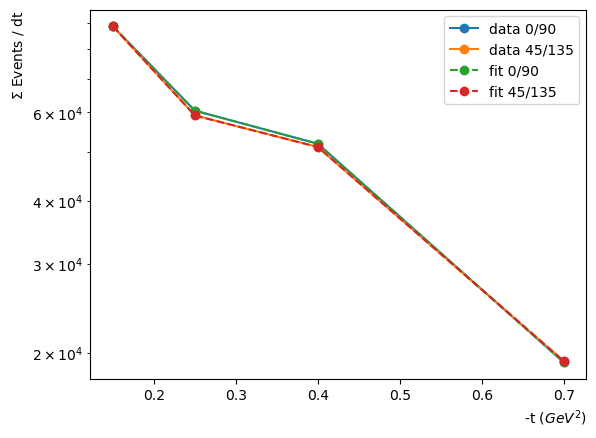

In [5]:
x = [0.15, 0.25, 0.4, 0.7] # center of t bins
t_cuts = ["0.1-0.2", "0.2-0.3", "0.3-0.5", "0.5-0.9"]

y_data_0_90 = []
y_data_45_135 = []
y_fit_0_90 = []
y_fit_45_135 = []
for t_cut in t_cuts:
    y_data_0_90.append(df_data[(df_data["orientation"]=="0-90") & (df_data["t"]==t_cut)]["bin_contents"][10])
    y_data_45_135.append(df_data[(df_data["orientation"]=="45-135") & (df_data["t"]==t_cut)]["bin_contents"][10])
    y_fit_0_90.append(df[(df["orientation"]=="0-90") & (df["t"]==t_cut)]["detected_events"][10])
    y_fit_45_135.append(df[(df["orientation"]=="45-135") & (df["t"]==t_cut)]["detected_events"][10])
print(y_fit_45_135)
plt.plot(x, y_data_0_90, label = "data 0/90", linestyle="-", marker="o")
plt.plot(x, y_data_45_135, label = "data 45/135", linestyle="-", marker="o")
plt.plot(x, y_fit_0_90, label = "fit 0/90", linestyle="--", marker="o")
plt.plot(x, y_fit_45_135, label = "fit 45/135", linestyle="--", marker="o")

plt.ylabel(r"$\Sigma$ Events / dt", loc="top")
plt.xlabel(r"-t $(GeV^2)$", loc="right")
plt.legend()
plt.yscale("log")

# Isotropic Background Check
A first look over the fit dataframe reveals significant contribution from the isotropic background wave in some bins. Initially, this is very unexpected as these waves were practically 0 in the initial t = [0.4 0.5] binned fits

Perhaps its a function of $t$? Lets try plotting the sum of the background across mass bins as a function of t

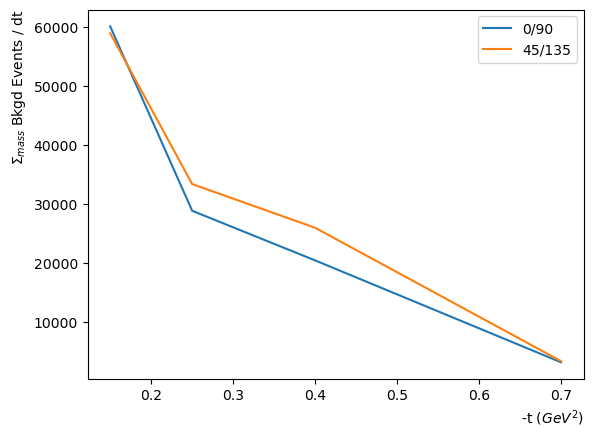

In [6]:
x = [0.15, 0.25, 0.4, 0.7] # center of t bins
t_cuts = ["0.1-0.2", "0.2-0.3", "0.3-0.5", "0.5-0.9"]
y_0_90 = []
y_45_135 = []
for t_cut in t_cuts:
    y_0_90.append(df[(df["orientation"]=="0-90") & (df["t"]==t_cut)]["Bkgd"].sum())
    y_45_135.append(df[(df["orientation"]=="45-135") & (df["t"]==t_cut)]["Bkgd"].sum())

plt.plot(x, y_0_90, label="0/90")
plt.plot(x, y_45_135, label="45/135")
plt.xlabel(r"-t $(GeV^2)$", loc="right")
plt.ylabel(r"$\Sigma_{mass}$ Bkgd Events / dt", loc="top")
plt.legend()

Looks like its pair independent, and is very significant across t bins. Next step will be checking if a particular mass bin is the culprit across all datasets. Here the background's fit fraction for all datasets will be plotted on the same mass spectrum.

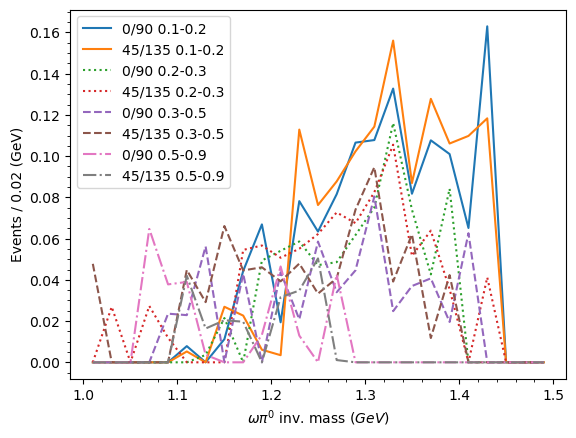

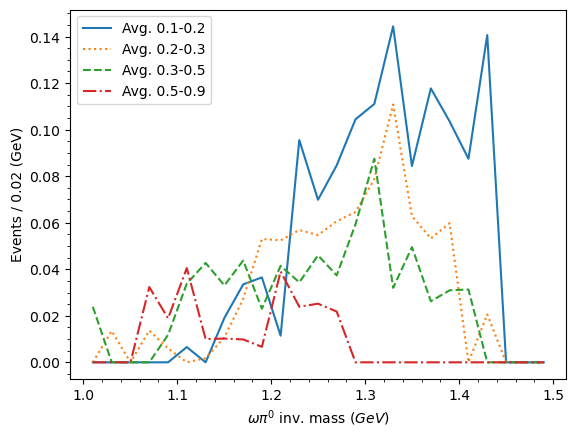

In [7]:
t_cuts = ["0.1-0.2", "0.2-0.3", "0.3-0.5", "0.5-0.9"]
t_lines = ["solid", "dotted", "dashed", "dashdot"]
for i, t_cut in enumerate(t_cuts):
    bkgd_0_90 = df[(df["orientation"]=="0-90") & (df["t"]==t_cut)]["Bkgd"]
    data_0_90 = df[(df["orientation"]=="0-90") & (df["t"]==t_cut)]["detected_events"]

    bkgd_45_135 = df[(df["orientation"]=="45-135") & (df["t"]==t_cut)]["Bkgd"]
    data_45_135 = df[(df["orientation"]=="45-135") & (df["t"]==t_cut)]["detected_events"]
    
    plt.plot(MASS_BINS, bkgd_0_90/data_0_90, linestyle=t_lines[i], label=f"0/90 {t_cut}")
    plt.plot(MASS_BINS, bkgd_45_135/data_45_135, linestyle=t_lines[i], label=f"45/135 {t_cut}")

plt.xlabel(r"$\omega\pi^0$ inv. mass $(GeV)$")
plt.ylabel(r"Events / 0.02 (GeV)")
plt.minorticks_on()
plt.legend()
plt.show()

# plot the average fit fraction of both orientations
for i, t_cut in enumerate(t_cuts):
    bkgd_0_90 = df[(df["orientation"]=="0-90") & (df["t"]==t_cut)]["Bkgd"]
    data_0_90 = df[(df["orientation"]=="0-90") & (df["t"]==t_cut)]["detected_events"]

    bkgd_45_135 = df[(df["orientation"]=="45-135") & (df["t"]==t_cut)]["Bkgd"]
    data_45_135 = df[(df["orientation"]=="45-135") & (df["t"]==t_cut)]["detected_events"]
    
    plt.plot(MASS_BINS, (bkgd_0_90/data_0_90 + bkgd_45_135/data_45_135) / 2, linestyle=t_lines[i], label=f"Avg. {t_cut}")    

plt.xlabel(r"$\omega\pi^0$ inv. mass $(GeV)$")
plt.ylabel(r"Events / 0.02 (GeV)")
plt.minorticks_on()
plt.legend()
plt.show()


It looks like when $t < 0.5$ the background wave peaks in the 1.3 to 1.4 mass region.

Lets check to see if any other correlations with the background wave exist

likelihood         -0.691337
detected_events     0.669400
generated_events    0.692531
Bkgd                1.000000
p1mpP_err           0.635392
1mP_err             0.618712
p1mp_err            0.635392
p1mP_err            0.604129
p1m_err             0.604129
1m_err              0.618712
Name: Bkgd, dtype: float64


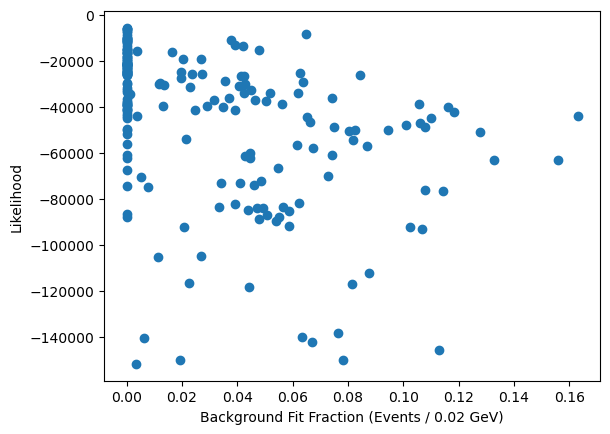

In [8]:
corr_series = df.drop(["orientation", "t"],axis=1).corr()["Bkgd"]

print(corr_series[abs(corr_series) > 0.6 ])

plt.scatter(df["Bkgd"]/df["detected_events"], df["likelihood"])
plt.xlabel("Background Fit Fraction (Events / 0.02 GeV)")
plt.ylabel("Likelihood")
plt.show()

When looking at the 1D angular distributions, there's a noticeable difference between those in the t=[0.5,0.9] bin The fit does not meet the high $\cos\theta$ values, or the $\Delta^+ \rightarrow p\pi^0$ region, whereas it does do a much better job fitting those areas in the t=[0.1,0.2] bin. I don't have access to the background's contribution in the `vecps_plot.root` file to see this directly unfortunately. This would explain why not all the fits with significant background contribution have bad likelihoods, as they are meeting the $\cos\theta$ fit variable better

# Analysis

## $b_1$ and $\rho^\ast$ interaction

Past studies indicate the $1^+ S_0^+$ and $1^- P_1^+$ waves capture the $b_1$ and $\rho^\ast$ resonances respectively. Plotting their intensities and phase as a function of mass will show whether these are present and stable in the data

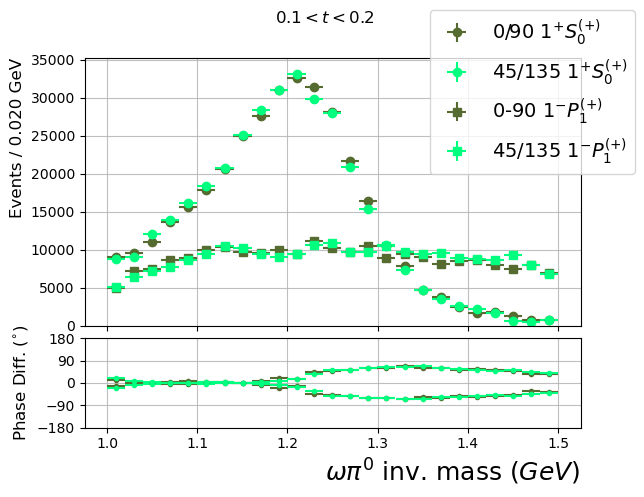

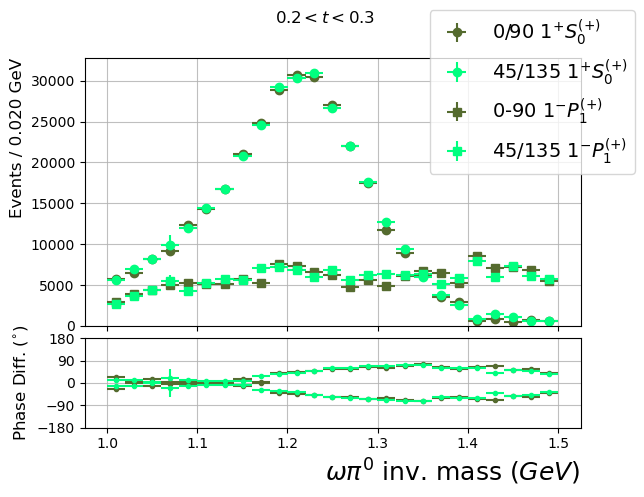

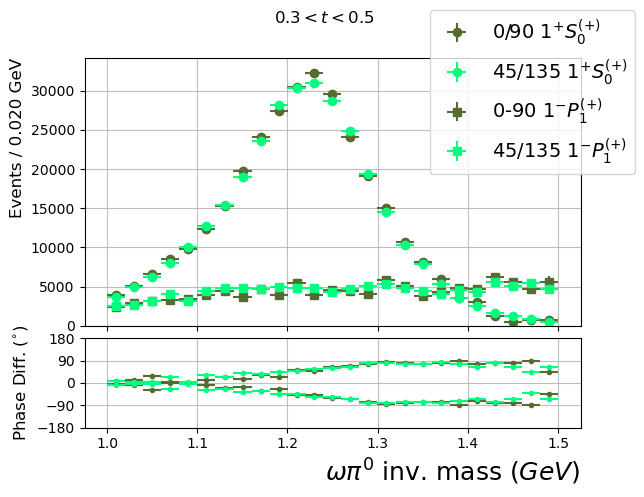

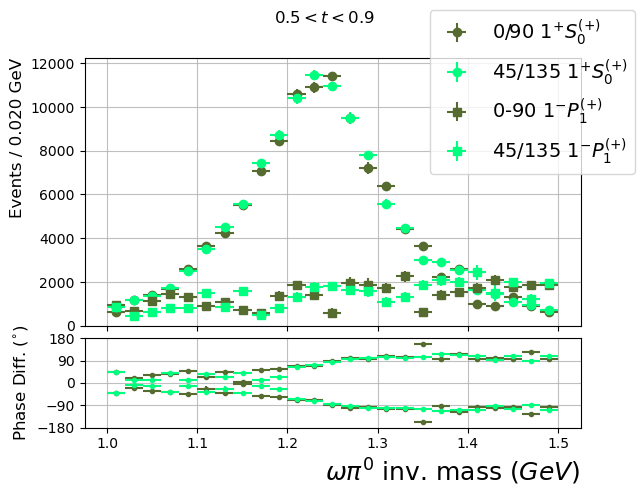

In [14]:
# basically copying the pwa_tools.Plotter.mass_phase method but including both orientations on one plot
def mass_phase(t_range):
    fig, axs = plt.subplots(
                2,
                1,
                sharex=True,
                gridspec_kw={"wspace": 0.0, "hspace": 0.07},
                height_ratios=[3, 1],
            )

    axs[0].errorbar(
        MASS_BINS, 
        df[(df["orientation"]=="0-90") & (df["t"]==t_range)]["p1p0S"],
        df[(df["orientation"]=="0-90") & (df["t"]==t_range)]["p1p0S_err"],     
        bin_width/2,
        "o", color="darkolivegreen", label=f"0/90 {pwa_tools.convert_amp_name('p1p0S')}",
    )
    axs[0].errorbar(
        MASS_BINS, 
        df[(df["orientation"]=="45-135") & (df["t"]==t_range)]["p1p0S"],
        df[(df["orientation"]=="45-135") & (df["t"]==t_range)]["p1p0S_err"],     
        bin_width/2,
        "o", color="springgreen", label=f"45/135 {pwa_tools.convert_amp_name('p1p0S')}",
    )
    axs[0].errorbar(
        MASS_BINS, 
        df[(df["orientation"]=="0-90") & (df["t"]==t_range)]["p1mpP"],
        df[(df["orientation"]=="0-90") & (df["t"]==t_range)]["p1mpP_err"],     
        bin_width/2,
        "s", color="darkolivegreen", label=f"0-90 {pwa_tools.convert_amp_name('p1mpP')}",
    )
    axs[0].errorbar(
        MASS_BINS, 
        df[(df["orientation"]=="45-135") & (df["t"]==t_range)]["p1mpP"],
        df[(df["orientation"]=="45-135") & (df["t"]==t_range)]["p1mpP_err"],     
        bin_width/2,
        "s", color="springgreen", label=f"45/135 {pwa_tools.convert_amp_name('p1mpP')}",
    )


    phase_dif = phase_differences[("p1p0S", "p1mpP")]
    axs[1].errorbar(
        MASS_BINS,
        df[(df["orientation"]=="0-90") & (df["t"]==t_range)][phase_dif].apply(np.rad2deg),
        df[(df["orientation"]=="0-90") & (df["t"]==t_range)][phase_dif + "_err"].abs().apply(np.rad2deg),
        bin_width / 2,
        linestyle="", marker=".", color="darkolivegreen"
    )
    axs[1].errorbar(
        MASS_BINS,
        -df[(df["orientation"]=="0-90") & (df["t"]==t_range)][phase_dif].apply(np.rad2deg),
        df[(df["orientation"]=="0-90") & (df["t"]==t_range)][phase_dif + "_err"].abs().apply(np.rad2deg),
        bin_width / 2,
        linestyle="", marker=".", color="darkolivegreen"
    )
    axs[1].errorbar(
        MASS_BINS,
        df[(df["orientation"]=="45-135") & (df["t"]==t_range)][phase_dif].apply(np.rad2deg),
        df[(df["orientation"]=="45-135") & (df["t"]==t_range)][phase_dif + "_err"].abs().apply(np.rad2deg),
        bin_width / 2,
        linestyle="", marker=".", color="springgreen"
    )
    axs[1].errorbar(
        MASS_BINS,
        -df[(df["orientation"]=="45-135") & (df["t"]==t_range)][phase_dif].apply(np.rad2deg),
        df[(df["orientation"]=="45-135") & (df["t"]==t_range)][phase_dif + "_err"].abs().apply(np.rad2deg),
        bin_width / 2,
        linestyle="", marker=".", color="springgreen"
    )

    # cosmetics
    for ax in axs.reshape(-1):
        ax.grid(True, alpha=0.8)

    axs[0].set_ylim(bottom=0.0)
    axs[0].set_ylabel(f"Events / {bin_width:.3f} GeV", loc="top", fontsize=12)

    axs[1].set_yticks(np.linspace(-180, 180, 5))  # force to be in pi/2 intervals
    axs[1].set_ylim([-180, 180])
    axs[1].set_ylabel(r"Phase Diff. ($^{\circ}$)", loc="center", fontsize=12)
    axs[1].set_xlabel(r"$\omega\pi^0$ inv. mass $(GeV)$", loc="right", fontsize=18)

    fig.legend(fontsize=14, loc="upper right")
    fig.suptitle(rf"${t_range[0:3]} < t < {t_range[4:7]}$")
    plt.show()

mass_phase("0.1-0.2")
mass_phase("0.2-0.3")
mass_phase("0.3-0.5")
mass_phase("0.5-0.9")

## Intensities
Now lets see how all the other intensities are fairing

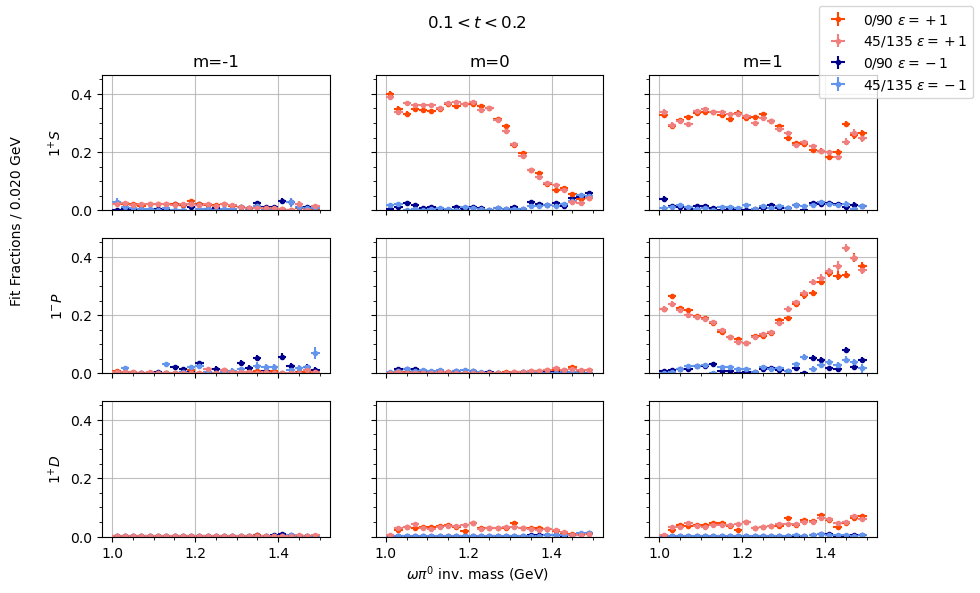

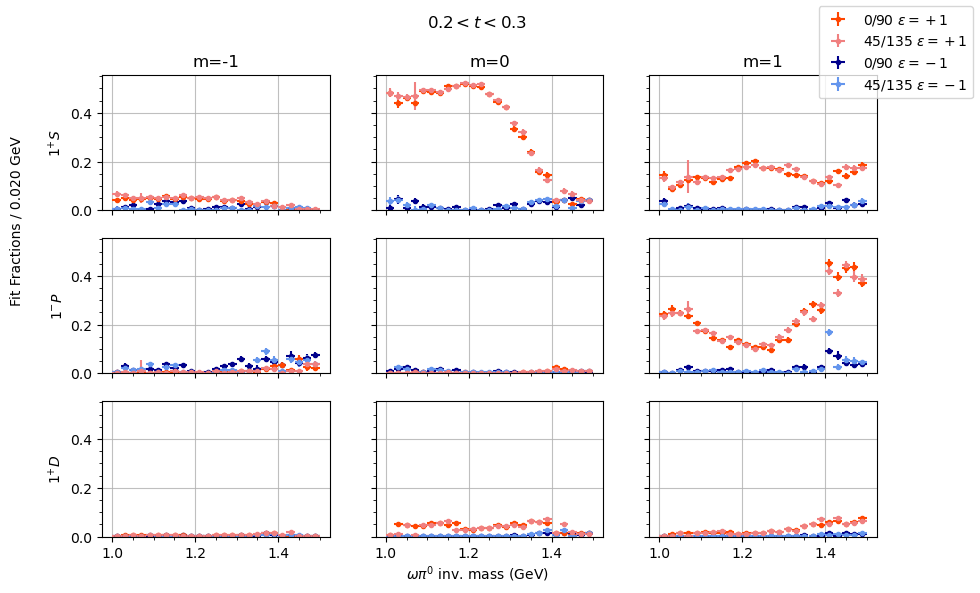

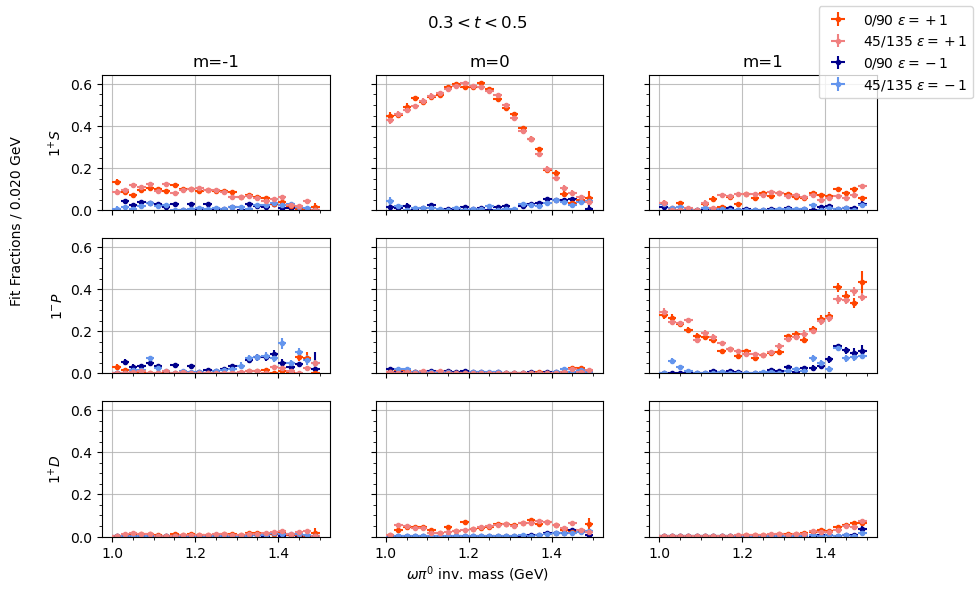

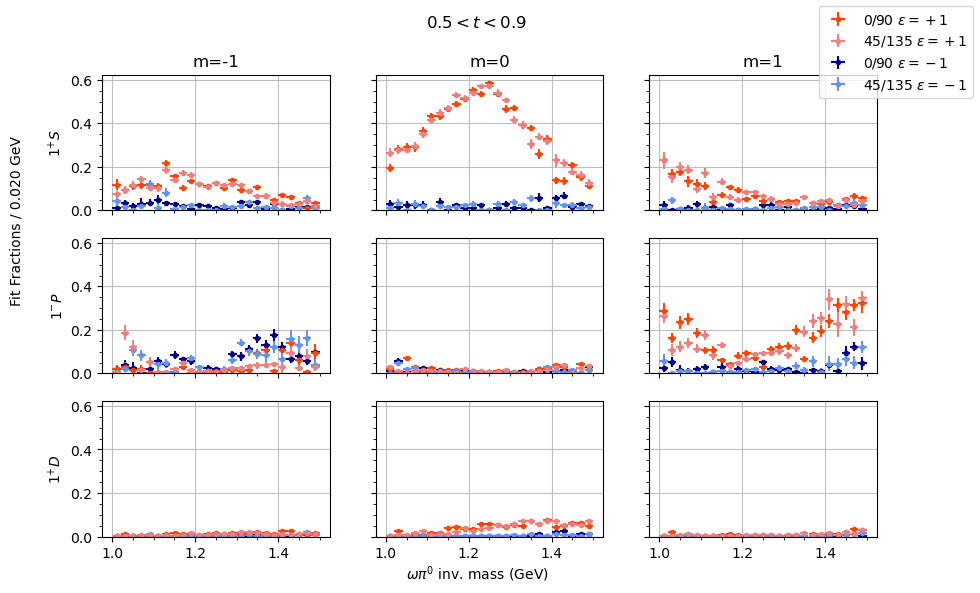

In [55]:
# code is basically a copy of the pwa_tools.Plotter.intensities() method
char_to_int = {"m": -1, "0": 0, "p": +1, "S": 0, "P": 1, "D": 2, "F": 3}
int_to_char = {-1: "m", 0: "0", +1: "p"}
pm_dict = {"m": "-", "p": "+"}

# need to sort on the integer versions of the m-projections
m_ints = sorted({char_to_int[JPm[-1]] for JPm in coherent_sums["JPm"]})

t_cuts = ["0.1-0.2", "0.2-0.3", "0.3-0.5", "0.5-0.9"]

for t_cut in t_cuts:
    fig, axs = plt.subplots(
        len(m_ints),
        len(coherent_sums["JPL"]),
        sharex=True,
        sharey=True,
        figsize=(10,6)
    )
    total_0_90 = df_data[(df_data["orientation"]=="0-90") & (df_data["t"]==t_cut)]["bin_contents"]
    total_0_90_err = df_data[(df_data["orientation"]=="0-90") & (df_data["t"]==t_cut)]["bin_error"]
    total_45_135 = df_data[(df_data["orientation"]=="45-135") & (df_data["t"]==t_cut)]["bin_contents"]
    total_45_135_err = df_data[(df_data["orientation"]=="45-135") & (df_data["t"]==t_cut)]["bin_error"]

    # total_0_90 = 1
    # total_0_90_err = 0
    # total_45_135 = 1
    # total_45_135_err = 0

    cut_df_0_90 = df[(df["orientation"]=="0-90") & (df["t"]==t_cut)]
    cut_df_45_135 = df[(df["orientation"]=="45-135") & (df["t"]==t_cut)]

    # iterate through JPL (sorted like S, P, D, F wave) and sorted m-projections
    for row, jpl in enumerate(
        sorted(coherent_sums["JPL"], key=lambda JPL: char_to_int[JPL[-1]])
    ):
        for col, m in enumerate(m_ints):
            JPmL = f"{jpl[0:2]}{int_to_char[m]}{jpl[-1]}"

            if row == 0:
                axs[row, col].set_title(f"m={char_to_int[JPmL[-2]]}")
            if col == 0:
                axs[row, col].set_ylabel(rf"${JPmL[0]}^{{{pm_dict[JPmL[1]]}}}{JPmL[-1]}$")            

            neg_plot_0_90 = axs[row, col].errorbar(
                MASS_BINS,
                cut_df_0_90["m" + JPmL] / total_0_90,
                (cut_df_0_90["m" + JPmL] / total_0_90) * np.sqrt(np.square(cut_df_0_90["m"+JPmL+"_err"]/cut_df_0_90["m"+JPmL]) + np.square(total_0_90_err / total_0_90)),
                bin_width / 2,
                ".",
                color="darkblue",                
                label=r"0/90 $\epsilon=-1$",
            )
            pos_plot_0_90 = axs[row, col].errorbar(
                MASS_BINS,
                cut_df_0_90["p" + JPmL] / total_0_90,
                (cut_df_0_90["p" + JPmL] / total_0_90) * np.sqrt(np.square(cut_df_0_90["p"+JPmL+"_err"]/cut_df_0_90["p"+JPmL]) + np.square(total_0_90_err / total_0_90)),
                bin_width / 2,
                ".",
                color="orangered",                
                label=r"0/90 $\epsilon=+1$",
            )

            neg_plot_45_135 = axs[row, col].errorbar(
                MASS_BINS,
                cut_df_45_135["m" + JPmL] / total_45_135,
                (cut_df_45_135["m" + JPmL] / total_45_135) * np.sqrt(np.square(cut_df_45_135["m"+JPmL+"_err"]/cut_df_45_135["m"+JPmL]) + np.square(total_45_135_err / total_45_135)),
                bin_width / 2,
                ".",
                color="cornflowerblue",                
                label=r"45/135 $\epsilon=-1$",
            )
            pos_plot_45_135 = axs[row, col].errorbar(
                MASS_BINS,
                cut_df_45_135["p" + JPmL] / total_45_135,
                (cut_df_45_135["p" + JPmL] / total_45_135) * np.sqrt(np.square(cut_df_45_135["p"+JPmL+"_err"]/cut_df_45_135["p"+JPmL]) + np.square(total_45_135_err / total_45_135)),
                bin_width / 2,
                ".",
                color="lightcoral",                
                label=r"45/135 $\epsilon=+1$",
            )

    # plot grids
    for ax in axs.reshape(-1):
        ax.grid(True, alpha=0.8)
        ax.set_ylim(bottom=0)
    plt.minorticks_on()        

    # figure cosmetics
    fig.text(0.5, 0.04, r"$\omega\pi^0$ inv. mass (GeV)", ha="center")
    fig.text(
        0.04,
        0.5,
        f"Fit Fractions / {bin_width:.3f} GeV",
        ha="center",        
        rotation="vertical",
    )
    fig.suptitle(rf"${t_cut[0:3]} < t < {t_cut[4:7]}$")
    fig.legend(handles=[pos_plot_0_90, pos_plot_45_135, neg_plot_0_90, neg_plot_45_135], loc="upper right")
    plt.show()

A couple immediate observations:
* The fit results match very well between orientations except in the last $-t$ bin 
* The strength of the $1^- P_1^+$, and $1^+ S_{\pm 1}^+$ waves change strongly across the t-range. Would be interesting to plot in the ALL orientation results
* Instabilities in the $1^- P_{\pm 1}^{\pm}$ waves seem to be shared

In regards to that last point, lets plot the 4 correlations between those waves as a function of t

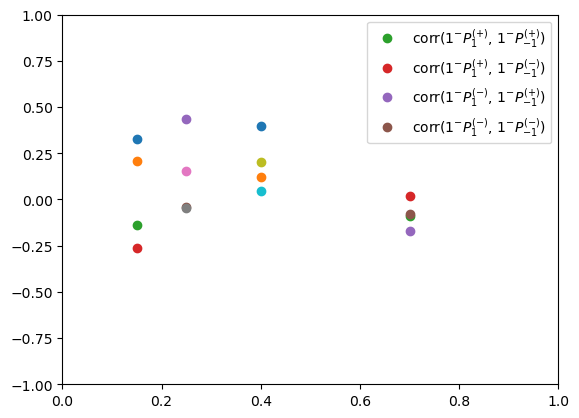

In [48]:
t_cuts = ["0.1-0.2", "0.2-0.3", "0.3-0.5", "0.5-0.9"]
t = [0.15, 0.25, 0.4, 0.7]

for i, t_cut in enumerate(t_cuts):
    # corr_{reflectivity}{m projection}
    corr_pp_pm = df[df["t"]==t_cut]["p1mpP"].corr(df[df["t"]==t_cut]["p1mmP"])
    corr_pp_mm = df[df["t"]==t_cut]["p1mpP"].corr(df[df["t"]==t_cut]["m1mmP"])
    corr_mp_pm = df[df["t"]==t_cut]["m1mpP"].corr(df[df["t"]==t_cut]["p1mmP"])
    corr_mp_mm = df[df["t"]==t_cut]["m1mpP"].corr(df[df["t"]==t_cut]["m1mmP"])    

    pp_pm = plt.plot(t[i], corr_pp_pm, label=f"corr({pwa_tools.convert_amp_name("p1mpP")}, {pwa_tools.convert_amp_name("p1mmP")})", linestyle="", marker="o")
    pp_mm = plt.plot(t[i], corr_pp_mm, label=f"corr({pwa_tools.convert_amp_name("p1mpP")}, {pwa_tools.convert_amp_name("m1mmP")})", linestyle="", marker="o")
    mp_pm = plt.plot(t[i], corr_mp_pm, label=f"corr({pwa_tools.convert_amp_name("m1mpP")}, {pwa_tools.convert_amp_name("p1mmP")})", linestyle="", marker="o")
    mp_mm = plt.plot(t[i], corr_mp_mm, label=f"corr({pwa_tools.convert_amp_name("m1mpP")}, {pwa_tools.convert_amp_name("m1mmP")})", linestyle="", marker="o")

plt.legend(handles=[pp_pm[0], pp_mm[0], mp_pm[0], mp_mm[0]])
plt.ylim([-1,1])
plt.xlim([0, 1.0])
plt.show()

## Cross Section

Before we go about trying to plot the cross section, lets see what just the total $1^+ \Sigma \ell_{\Sigma m}^+$ coherent sum looks like to check whether its shape is even breit wigner like across t bins

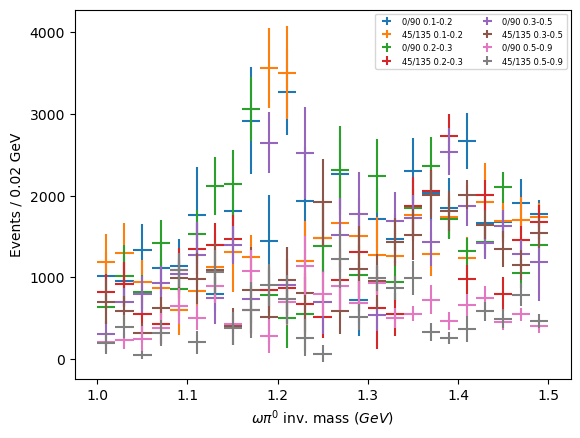

In [54]:
t_cuts = ["0.1-0.2", "0.2-0.3", "0.3-0.5", "0.5-0.9"]

for t_cut in t_cuts:
    plt.errorbar(
        MASS_BINS, 
        df[(df["orientation"]=="0-90") & (df["t"]==t_cut)]["m1p"], 
        df[(df["orientation"]=="0-90") & (df["t"]==t_cut)]["m1p_err"],
        bin_width/2,
        linestyle="",
        label=f"0/90 {t_cut}"
    )
    plt.errorbar(
        MASS_BINS, 
        df[(df["orientation"]=="45-135") & (df["t"]==t_cut)]["m1p"], 
        df[(df["orientation"]=="45-135") & (df["t"]==t_cut)]["m1p_err"],
        bin_width/2,
        linestyle="",
        label=f"45/135 {t_cut}"
    )

plt.ylabel("Events / 0.02 GeV")
plt.xlabel(r"$\omega\pi^0$ inv. mass $(GeV)$")
plt.legend(ncol=2, loc="upper right", fontsize=6)
plt.show()

The cross section for each orientation will likely be low compared to theory as the number of observed events $N_{obs}$ is halved for each, but we can check for consistency between orientation pairs. As opposed to previous calculations, this will depend more heavily on the breit wigner fraction $f$ since the measurement will only be extracted from the 20 MeV wide 1.22-1.24 GeV mass bin 

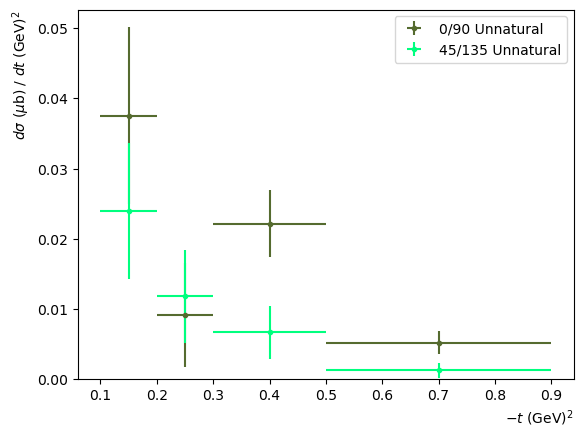

In [12]:
import scipy.integrate as integrate

# very simple relativistic breit wigner without any barrier factors. DO NOT INTEGRATE FROM -INF AS THE LOWER BOUND
def breit_wigner(x, m, width):
    gamma = math.sqrt(m**2 * (m**2 + width**2))

    k = (2 * math.sqrt(2) * m * width * gamma) / (math.pi * math.sqrt(m**2 + gamma))

    result = k / ((x**2 - m**2) ** 2 + m**2 * width**2)

    return result

# get fraction of b1 breit wigner covered by the mass bin and other constants
total_int = integrate.quad(breit_wigner, 0, math.inf, args=(1.235, 0.142))
bin_int = integrate.quad(breit_wigner, 1.22, 1.24, args=(1.235, 0.142))
frac = 1 / (bin_int[0] / total_int[0])
LUM = 117858000  # ub^{-1} (old 125000000)
BF = 0.892  # omega->3pi branching fraction (from pdg)

t_bins = [0.15, 0.25, 0.4, 0.7]
t_width = np.array([0.1, 0.1, 0.2, 0.4])

factor = frac * (1/(BF*LUM*t_width))

# grab t binned csvs (the intensity results are acceptance corrected)
path = f"{parent_dir}/analysis/data"
cs_df_0_90 = pd.read_csv(f"{path}/0-90_m-1.22-1.24.csv", index_col="index")
cs_df_45_135 = pd.read_csv(f"{path}/45-135_m-1.22-1.24.csv", index_col="index")
df_theory = pd.read_csv(f"{path}/piExch-B1neutral.txt", sep=r"\s+", names=["t", "dsigma"])

plt.errorbar(
    t_bins,
    cs_df_0_90["m1p"]*factor, 
    cs_df_0_90["m1p_err"]*factor,
    t_width/2,
    color="darkolivegreen",
    marker=".",
    linestyle="",
    label="0/90 Unnatural"
)
plt.errorbar(
    t_bins,
    cs_df_45_135["m1p"]*factor, 
    cs_df_45_135["m1p_err"]*factor,
    t_width/2,
    color="springgreen",
    marker=".",
    linestyle="",
    label="45/135 Unnatural"
)
# plt.plot(
#     df_theory["t"],
#     df_theory["dsigma"],
#     color="#0076BA",
#     marker="",
#     linestyle="-",
#     linewidth=2.0,
#     label="Unnatural (JPAC Calculation)",
# )

# Cosmetics
plt.xlabel(r"$-t$ (GeV)$^{{2}}$", loc="right")
plt.ylabel(r"$d\sigma$ ($\mu$b) / $dt$ (GeV)$^2$", loc="top")
plt.gca().set_ylim(bottom=0)

plt.legend()
plt.show()

As expected this seems to be very sensitive to the fit changing. The background wave is anywhere from 2-12% in this mass region, so its likely pulling from the negative reflectivity contributions

### Reflectivity Fraction
To drive home the point of how unstable these amplitudes are, we can plot the fractional contribution of each reflectivity as a function of $-t$ (only for the $1^+$ amplitudes)

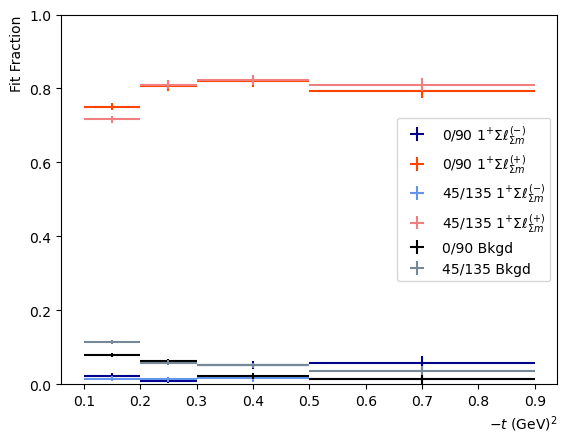

In [22]:
t_bins = [0.15, 0.25, 0.4, 0.7]
t_width = np.array([0.1, 0.1, 0.2, 0.4])
plt.errorbar(
    t_bins,
    cs_df_0_90["m1p"] / cs_df_0_90["generated_events"],
    (cs_df_0_90["m1p"] / cs_df_0_90["generated_events"]) * np.sqrt(np.square(cs_df_0_90["m1p_err"]/cs_df_0_90["m1p"]) + np.square(cs_df_0_90["generated_events_err"]/cs_df_0_90["generated_events"])),
    t_width/2,
    linestyle="",
    color="darkblue",
    label=rf"0/90 {pwa_tools.convert_amp_name("m1p")}"
)
plt.errorbar(
    t_bins,
    cs_df_0_90["p1p"] / cs_df_0_90["generated_events"],
    (cs_df_0_90["p1p"] / cs_df_0_90["generated_events"]) * np.sqrt(np.square(cs_df_0_90["p1p_err"]/cs_df_0_90["p1p"]) + np.square(cs_df_0_90["generated_events_err"]/cs_df_0_90["generated_events"])),
    t_width/2,
    linestyle="",
    color="orangered",
    label=rf"0/90 {pwa_tools.convert_amp_name("p1p")}"
)

plt.errorbar(
    t_bins,
    cs_df_45_135["m1p"] / cs_df_45_135["generated_events"],
    (cs_df_45_135["m1p"] / cs_df_45_135["generated_events"]) * np.sqrt(np.square(cs_df_45_135["m1p_err"]/cs_df_45_135["m1p"]) + np.square(cs_df_45_135["generated_events_err"]/cs_df_45_135["generated_events"])),
    t_width/2,
    linestyle="",
    color="cornflowerblue",
    label=rf"45/135 {pwa_tools.convert_amp_name("m1p")}"
)
plt.errorbar(
    t_bins,
    cs_df_45_135["p1p"] / cs_df_45_135["generated_events"],
    (cs_df_45_135["p1p"] / cs_df_45_135["generated_events"]) * np.sqrt(np.square(cs_df_45_135["p1p_err"]/cs_df_45_135["p1p"]) + np.square(cs_df_45_135["generated_events_err"]/cs_df_45_135["generated_events"])),
    t_width/2,
    linestyle="",
    color="lightcoral",
    label=rf"45/135 {pwa_tools.convert_amp_name("p1p")}"
)
# plot the background fit fraction too
plt.errorbar(
    t_bins,
    cs_df_0_90["Bkgd"] / cs_df_0_90["generated_events"],
    (cs_df_0_90["Bkgd"] / cs_df_0_90["generated_events"]) * np.sqrt(np.square(cs_df_0_90["Bkgd_err"]/cs_df_0_90["Bkgd"]) + np.square(cs_df_0_90["generated_events_err"]/cs_df_0_90["generated_events"])),
    t_width/2,
    linestyle="",
    color="black",
    label="0/90 Bkgd"
)
plt.errorbar(
    t_bins,
    cs_df_45_135["Bkgd"] / cs_df_45_135["generated_events"],
    (cs_df_45_135["Bkgd"] / cs_df_45_135["generated_events"]) * np.sqrt(np.square(cs_df_45_135["Bkgd_err"]/cs_df_45_135["Bkgd"]) + np.square(cs_df_45_135["generated_events_err"]/cs_df_45_135["generated_events"])),
    t_width/2,
    linestyle="",
    color="lightslategray",
    label="45/135 Bkgd"
)

plt.xlabel(r"$-t$ (GeV)$^{{2}}$", loc="right")
plt.ylabel(r"Fit Fraction", loc="top")
plt.ylim([0.0,1.0])
plt.legend()
plt.show()
